## This project is a demonstration of how we can use streamed twitter data that is stored in our AWS bucket, add labels and build a sentiment analysis model using natural language processing packages on Python

In [1]:
#import necessary libraries

import re
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import boto3
from sagemaker import get_execution_role
import sagemaker

#nltk
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')


[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ec2-user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
#Load the streamed data from S3 bucket
role = get_execution_role()
bucket = 'twitter-stuff-bucket'
#sub_folder = 'twitter-dataset'
#data_key ='train'
data_key = 'twitter-delivery-stream-15-2021-12-26-15-26-32-25a4c363-7c9d-4b2f-9257-18ccd351cbc0'
data_location = 's3://{}/{}'.format(bucket, data_key)
#print(data_location)

In [3]:
#read data -- lines=True because we are reading each line as a JSON object
df = pd.read_json(data_location, lines=True)
df.head().T


,0,1,2,3,4
created_at,2021-12-26 15:26:26+00:00,2021-12-26 15:26:26+00:00,2021-12-26 15:26:26+00:00,2021-12-26 15:26:26+00:00,2021-12-26 15:26:26+00:00
id,1475125861196124165,1475125861871407107,1475125861808578560,1475125861892472833,1475125862232174596
id_str,1475125861196124160,1475125861871407104,1475125861808578560,1475125861892472832,1475125862232174592
text,RT @NYTHealth: Monclonal antibodies have becom...,RT @epaphotos: A man walks past a vaccination ...,@DipierroAnthony @ArisKatzourakis The overall ...,RT @marivarella: Fechar os olhos p/ o que está...,Will be joining @CNNnewsroom at 2 pm ET and sp...
source,"<a href=""http://twitter.com/download/iphone"" r...","<a href=""https://mobile.twitter.com"" rel=""nofo...","<a href=""https://mobile.twitter.com"" rel=""nofo...","<a href=""http://twitter.com/download/android"" ...","<a href=""http://twitter.com/download/iphone"" r..."
truncated,False,False,True,False,False
in_reply_to_status_id,NaN,NaN,1.47509e+18,NaN,NaN
in_reply_to_status_id_str,NaN,NaN,1.47509e+18,NaN,NaN
in_reply_to_user_id,NaN,NaN,3.81656e+09,NaN,NaN
in_reply_to_user_id_str,NaN,NaN,3.81656e+09,NaN,NaN


In [4]:
#check type of data & missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723 entries, 0 to 3722
Data columns (total 36 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 3723 non-null   datetime64[ns, UTC]
 1   id                         3723 non-null   int64              
 2   id_str                     3723 non-null   int64              
 3   text                       3723 non-null   object             
 4   source                     3723 non-null   object             
 5   truncated                  3723 non-null   bool               
 6   in_reply_to_status_id      271 non-null    float64            
 7   in_reply_to_status_id_str  271 non-null    float64            
 8   in_reply_to_user_id        293 non-null    float64            
 9   in_reply_to_user_id_str    293 non-null    float64            
 10  in_reply_to_screen_name    293 non-null    object             
 11  user

In [5]:
df.shape

(3723, 36)

There are 3723 rows and 36 colums

In [6]:
#language count
df['lang'].value_counts()

en     2264
hi      260
fr      257
es      248
und     185
tr      118
in       90
it       80
pt       71
ja       21
de       20
tl       16
zh       15
nl       15
ta       15
th       14
et        5
fi        4
ca        4
te        3
ar        3
cs        2
kn        2
sv        2
ml        2
da        2
lv        1
fa        1
bn        1
mr        1
pl        1
Name: lang, dtype: int64

About 60.8 % of the tweets are in English

In [7]:
df['length'] = df['text'].apply(len)

In [8]:
#added a length column
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3723 entries, 0 to 3722
Data columns (total 37 columns):
 #   Column                     Non-Null Count  Dtype              
---  ------                     --------------  -----              
 0   created_at                 3723 non-null   datetime64[ns, UTC]
 1   id                         3723 non-null   int64              
 2   id_str                     3723 non-null   int64              
 3   text                       3723 non-null   object             
 4   source                     3723 non-null   object             
 5   truncated                  3723 non-null   bool               
 6   in_reply_to_status_id      271 non-null    float64            
 7   in_reply_to_status_id_str  271 non-null    float64            
 8   in_reply_to_user_id        293 non-null    float64            
 9   in_reply_to_user_id_str    293 non-null    float64            
 10  in_reply_to_screen_name    293 non-null    object             
 11  user

In [9]:
df.describe()

,id,id_str,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,geo,coordinates,contributors,quote_count,reply_count,retweet_count,favorite_count,possibly_sensitive,quoted_status_id,quoted_status_id_str,length
count,3.723000e+03,3.723000e+03,2.710000e+02,2.710000e+02,2.930000e+02,2.930000e+02,0.0,0.0,0.0,3723.0,3723.0,3723.0,3723.0,582.000000,7.650000e+02,7.650000e+02,3723.000000
mean,1.475127e+18,1.475127e+18,1.474831e+18,1.474831e+18,4.202520e+17,4.202520e+17,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.022337,1.474408e+18,1.474408e+18,123.581252
std,5.601688e+11,5.601688e+11,1.977479e+15,1.977479e+15,5.792603e+17,5.792603e+17,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.147903,5.772016e+15,5.772016e+15,31.620016
min,1.475126e+18,1.475126e+18,1.443278e+18,1.443278e+18,7.421430e+05,7.421430e+05,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,1.335304e+18,1.335304e+18,1.000000
25%,1.475126e+18,1.475126e+18,1.474990e+18,1.474990e+18,1.436291e+08,1.436291e+08,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,1.474762e+18,1.474762e+18,124.000000
50%,1.475127e+18,1.475127e+18,1.475105e+18,1.475105e+18,1.200214e+09,1.200214e+09,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,1.474953e+18,1.474953e+18,140.000000
75%,1.475127e+18,1.475127e+18,1.475124e+18,1.475124e+18,1.037412e+18,1.037412e+18,NaN,NaN,NaN,0.0,0.0,0.0,0.0,0.000000,1.475102e+18,1.475102e+18,140.000000
max,1.475128e+18,1.475128e+18,1.475127e+18,1.475127e+18,1.469166e+18,1.469166e+18,NaN,NaN,NaN,0.0,0.0,0.0,0.0,1.000000,1.475127e+18,1.475127e+18,152.000000


In [10]:
#filter english tweets only
df_english=df[df['lang']=='en']


In [11]:
df_english

,created_at,id,id_str,text,source,truncated,in_reply_to_status_id,in_reply_to_status_id_str,in_reply_to_user_id,in_reply_to_user_id_str,...,timestamp_ms,display_text_range,extended_tweet,possibly_sensitive,quoted_status_id,quoted_status_id_str,quoted_status,quoted_status_permalink,extended_entities,length
0,2021-12-26 15:26:26+00:00,1475125861196124165,1475125861196124160,RT @NYTHealth: Monclonal antibodies have becom...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,2021-12-26 15:26:26.479,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140
1,2021-12-26 15:26:26+00:00,1475125861871407107,1475125861871407104,RT @epaphotos: A man walks past a vaccination ...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,NaN,NaN,NaN,...,2021-12-26 15:26:26.640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,139
2,2021-12-26 15:26:26+00:00,1475125861808578560,1475125861808578560,@DipierroAnthony @ArisKatzourakis The overall ...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",True,1.475092e+18,1.475092e+18,3.816557e+09,3.816557e+09,...,2021-12-26 15:26:26.625,"[34, 140]",{'full_text': '@DipierroAnthony @ArisKatzourak...,0.0,NaN,NaN,NaN,NaN,NaN,140
4,2021-12-26 15:26:26+00:00,1475125862232174596,1475125862232174592,Will be joining @CNNnewsroom at 2 pm ET and sp...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,2021-12-26 15:26:26.726,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,122
5,2021-12-26 15:26:26+00:00,1475125863343529985,1475125863343529984,RT @TrutherPatriot: My husband has Covid. I ca...,"<a href=""http://twitter.com/#!/download/ipad"" ...",False,NaN,NaN,NaN,NaN,...,2021-12-26 15:26:26.991,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3713,2021-12-26 15:34:10+00:00,1475127809345351683,1475127809345351680,RT @RWMaloneMD: Someone asked me the other day...,"<a href=""http://twitter.com/download/iphone"" r...",False,NaN,NaN,NaN,NaN,...,2021-12-26 15:34:10.954,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140
3714,2021-12-26 15:34:11+00:00,1475127810024898563,1475127810024898560,RT @PriyaHooda_: AKTU is conducting offline ex...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,2021-12-26 15:34:11.116,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140
3718,2021-12-26 15:34:12+00:00,1475127814345015296,1475127814345015296,RT @jethaa_ji: AKTU is conducting offline exam...,"<a href=""http://twitter.com/download/android"" ...",False,NaN,NaN,NaN,NaN,...,2021-12-26 15:34:12.146,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140
3720,2021-12-26 15:34:12+00:00,1475127815796371457,1475127815796371456,RT @TrutherPatriot: My husband has Covid. I ca...,"<a href=""https://mobile.twitter.com"" rel=""nofo...",False,NaN,NaN,NaN,NaN,...,2021-12-26 15:34:12.492,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140


In [12]:
df_english.shape #2264 english tweets

(2264, 37)

            ###  Data Cleaning
            
            --Dropping all columns except Date, the tweet text

In [13]:
df_english_tweetonly=df_english[['created_at','text']]
df_english_tweetonly

,created_at,text
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...
...,...,...
3713,2021-12-26 15:34:10+00:00,RT @RWMaloneMD: Someone asked me the other day...
3714,2021-12-26 15:34:11+00:00,RT @PriyaHooda_: AKTU is conducting offline ex...
3718,2021-12-26 15:34:12+00:00,RT @jethaa_ji: AKTU is conducting offline exam...
3720,2021-12-26 15:34:12+00:00,RT @TrutherPatriot: My husband has Covid. I ca...


In [14]:
df_english_tweetonly['text'].duplicated(keep='first').sum()

1128

#About half are duplicates, but I intend not to drop them

#df_english_tweetonly = df_english_tweetonly.drop_duplicates(subset='text'='first')



In [15]:
df_english_tweetonly.shape

(2264, 2)

In [16]:
#initializing Lemmatizer and stopwords
lemma = WordNetLemmatizer()
stop_words = stopwords.words("english")

In [17]:
# define a function to clean the tweet.
''' 
Change to lower case
remove 'rt' (denoting retweet)
Replace URLs with space
Replace user names with space
Replace anything not a letter or apostrophe with space
Remove single letter words
lemmatize, tokenize (nouns and verb), remove stop words, filter all the non-alphabetic words, then join them again

'''


def clean_tweet(tweet):
    tweet = tweet.lower()
    tweet = re.sub('rt', ' ', tweet)
    tweet = re.sub('https?:\/\/[a-zA-Z0-9@:%._\/+~#=?&;-]*', ' ', tweet)
    #tweet = re.sub('\$[a-zA-Z0-9]*', ' ', tweet)
    tweet = re.sub('\@[a-zA-Z0-9]*', ' ', tweet)
    tweet = re.sub('[^a-zA-Z\']', ' ', tweet)
    tweet = ' '.join( [w for w in tweet.split() if len(w)>1] )
    
    tweet=' '.join([lemma.lemmatize(x) for x in nltk.wordpunct_tokenize(tweet) if x not in stop_words])
    tweet=[lemma.lemmatize(x,nltk.corpus.reader.wordnet.VERB) for x in nltk.wordpunct_tokenize(tweet) if x not in stop_words]
    return tweet 

In [18]:

# clean tweets
#df_english_tweetonly=df_english_tweetonly['text'].astype(str)
df_english_tweetonly['clean_tweet']=df_english_tweetonly['text'].apply(lambda x:clean_tweet(x))
df_english_tweetonly['cleaned_tweet']=df_english_tweetonly['clean_tweet'].apply(lambda x:' '.join(x))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [19]:
df_english_tweetonly

,created_at,text,clean_tweet,cleaned_tweet
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...
...,...,...,...,...
3713,2021-12-26 15:34:10+00:00,RT @RWMaloneMD: Someone asked me the other day...,"[someone, ask, day, know, government, consider...",someone ask day know government consider pande...
3714,2021-12-26 15:34:11+00:00,RT @PriyaHooda_: AKTU is conducting offline ex...,"[aktu, conduct, offline, exam, amid, rise, omi...",aktu conduct offline exam amid rise omicron ca...
3718,2021-12-26 15:34:12+00:00,RT @jethaa_ji: AKTU is conducting offline exam...,"[ji, aktu, conduct, offline, exam, amid, rise,...",ji aktu conduct offline exam amid rise omicron...
3720,2021-12-26 15:34:12+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...


In [20]:
list(df_english_tweetonly['cleaned_tweet'])

['monclonal antibody become mainstay treat covid hospital abandon',
 'man walk past vaccination center barcelona spain spanish government decide make wear face mask',
 'overall chance hospitalization v delta lower omicron',
 'join pm et speak omicron holiday travel tip remain safe',
 'husband covid call get monoclonal antibody ct say sorry give omicr',
 'remember normalize everyone get omicron politics public health',
 "' finish afternoon even overnight call observation apology goin",
 'conduct online exam otherwise postpone syllabus complete omicron case increase day day',
 'university take exam either online open book examination aktu take semester ex',
 'want online exam student',
 'case omicron variant covid confirm kerala state health minister pti',
 "omicron ' mutate ' change covid symptom presentation loss smell taste sore throat run",
 'latest update total confirm case omicron variant malaysia returnees saudi arabia saudi',
 'news case omicron variant covid confirm kerala state

### Add labels to tweets:
Lets add random labels first and train the model. Later we can use VADER to analyse tweets and add labels and then use NB to build a model and assess performance between 2 models - This is a demonstration of how quality labels can affect a model's training peformance.

In [21]:
#just learning how to save the output to S3 bucket - not a necessary step
from io import StringIO

bucket = 'twitter-stuff-bucket-json' # already created on S3
csv_buffer = StringIO()
df_english_tweetonly['cleaned_tweet'].to_csv(csv_buffer)
s3_resource = boto3.resource('s3')
s3_resource.Object(bucket, 'df_english_tweetonly.csv').put(Body=csv_buffer.getvalue())

{'ResponseMetadata': {'RequestId': 'W8N8GX9342QJ1G3F',
  'HostId': '6nBjhEM+os7oXQqKikZwihpHsUyN6WSyLhif0As2f2Yx1rT8QFUOrVEv2C0M13SrXQs93sul76w=',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-id-2': '6nBjhEM+os7oXQqKikZwihpHsUyN6WSyLhif0As2f2Yx1rT8QFUOrVEv2C0M13SrXQs93sul76w=',
   'x-amz-request-id': 'W8N8GX9342QJ1G3F',
   'date': 'Thu, 30 Dec 2021 11:56:42 GMT',
   'etag': '"cc5db7e57d17f70a393da118f25c8fdd"',
   'server': 'AmazonS3',
   'content-length': '0'},
  'RetryAttempts': 0},
 'ETag': '"cc5db7e57d17f70a393da118f25c8fdd"'}

In [22]:
import numpy as np
df_english_tweetonly['label'] = np.random.randint(0,2, size=len(df_english_tweetonly))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [23]:
df_english_tweetonly.head(20)

,created_at,text,clean_tweet,cleaned_tweet,label
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...,1
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...,1
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...,0
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...,0
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,0
10,2021-12-26 15:26:28+00:00,RT @enenbee: Remember normalizing ‘everyone wi...,"[remember, normalize, everyone, get, omicron, ...",remember normalize everyone get omicron politi...,1
11,2021-12-26 15:26:28+00:00,RT @DrJacobsRad: I've just finished up my afte...,"[', finish, afternoon, even, overnight, call, ...",' finish afternoon even overnight call observa...,0
12,2021-12-26 15:26:28+00:00,RT @Praveen23466742: #Conduct online exam othe...,"[conduct, online, exam, otherwise, postpone, s...",conduct online exam otherwise postpone syllabu...,1
15,2021-12-26 15:26:28+00:00,RT @madityachaudhry: All other universities ar...,"[university, take, exam, either, online, open,...",university take exam either online open book e...,0
16,2021-12-26 15:26:29+00:00,RT @AbdulRe93322683: #एकेटीयू_ऑनलाइन_परीक्षा\n...,"[want, online, exam, student]",want online exam student,1


In [24]:
df_english_tweetonly

,created_at,text,clean_tweet,cleaned_tweet,label
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...,1
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...,1
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...,0
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...,0
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,0
...,...,...,...,...,...
3713,2021-12-26 15:34:10+00:00,RT @RWMaloneMD: Someone asked me the other day...,"[someone, ask, day, know, government, consider...",someone ask day know government consider pande...,0
3714,2021-12-26 15:34:11+00:00,RT @PriyaHooda_: AKTU is conducting offline ex...,"[aktu, conduct, offline, exam, amid, rise, omi...",aktu conduct offline exam amid rise omicron ca...,1
3718,2021-12-26 15:34:12+00:00,RT @jethaa_ji: AKTU is conducting offline exam...,"[ji, aktu, conduct, offline, exam, amid, rise,...",ji aktu conduct offline exam amid rise omicron...,0
3720,2021-12-26 15:34:12+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,1


In [25]:
df_english_tweetonly['label']

0       1
1       1
2       0
4       0
5       0
       ..
3713    0
3714    1
3718    0
3720    1
3721    0
Name: label, Length: 2264, dtype: int64

In [26]:
df_english_tweetonly.drop('label', axis=1, inplace=True)  

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [27]:
df_english_tweetonly

,created_at,text,clean_tweet,cleaned_tweet
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...
...,...,...,...,...
3713,2021-12-26 15:34:10+00:00,RT @RWMaloneMD: Someone asked me the other day...,"[someone, ask, day, know, government, consider...",someone ask day know government consider pande...
3714,2021-12-26 15:34:11+00:00,RT @PriyaHooda_: AKTU is conducting offline ex...,"[aktu, conduct, offline, exam, amid, rise, omi...",aktu conduct offline exam amid rise omicron ca...
3718,2021-12-26 15:34:12+00:00,RT @jethaa_ji: AKTU is conducting offline exam...,"[ji, aktu, conduct, offline, exam, amid, rise,...",ji aktu conduct offline exam amid rise omicron...
3720,2021-12-26 15:34:12+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...


In [28]:
import numpy as np
df_english_tweetonly['label'] = np.random.randint(0,2, size=len(df_english_tweetonly))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [29]:
df_english_tweetonly

,created_at,text,clean_tweet,cleaned_tweet,label
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...,1
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...,1
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...,0
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...,0
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,0
...,...,...,...,...,...
3713,2021-12-26 15:34:10+00:00,RT @RWMaloneMD: Someone asked me the other day...,"[someone, ask, day, know, government, consider...",someone ask day know government consider pande...,0
3714,2021-12-26 15:34:11+00:00,RT @PriyaHooda_: AKTU is conducting offline ex...,"[aktu, conduct, offline, exam, amid, rise, omi...",aktu conduct offline exam amid rise omicron ca...,0
3718,2021-12-26 15:34:12+00:00,RT @jethaa_ji: AKTU is conducting offline exam...,"[ji, aktu, conduct, offline, exam, amid, rise,...",ji aktu conduct offline exam amid rise omicron...,1
3720,2021-12-26 15:34:12+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,0


    ### Perform CountVectorization

In [30]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer()

tweets_countvectorizer = vectorizer.fit_transform(df_english_tweetonly['cleaned_tweet'].to_numpy())


In [31]:
tweets_countvectorizer.shape
tweets_countvectorizer

<2264x2925 sparse matrix of type '<class 'numpy.int64'>'
	with 22482 stored elements in Compressed Sparse Row format>

In [32]:
X = tweets_countvectorizer
y= df_english_tweetonly['label']

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [34]:
from sklearn.naive_bayes import MultinomialNB
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

In [35]:
from sklearn.metrics import classification_report, confusion_matrix

y_predict_test = NB_classifier.predict(X_test)

In [36]:
cm = confusion_matrix(y_test, y_predict_test)

<AxesSubplot:>

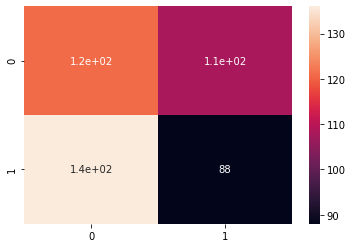

In [37]:
sns.heatmap(cm, annot=True)

In [38]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.47      0.53      0.50       229
           1       0.45      0.39      0.42       224

    accuracy                           0.46       453
   macro avg       0.46      0.46      0.46       453
weighted avg       0.46      0.46      0.46       453



Above for random labels the model gives an accuracy of 46%. Let's remove those labels and add labels using VADER lexicon

In [39]:
df_english_tweetonly

,created_at,text,clean_tweet,cleaned_tweet,label
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...,1
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...,1
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...,0
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...,0
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,0
...,...,...,...,...,...
3713,2021-12-26 15:34:10+00:00,RT @RWMaloneMD: Someone asked me the other day...,"[someone, ask, day, know, government, consider...",someone ask day know government consider pande...,0
3714,2021-12-26 15:34:11+00:00,RT @PriyaHooda_: AKTU is conducting offline ex...,"[aktu, conduct, offline, exam, amid, rise, omi...",aktu conduct offline exam amid rise omicron ca...,0
3718,2021-12-26 15:34:12+00:00,RT @jethaa_ji: AKTU is conducting offline exam...,"[ji, aktu, conduct, offline, exam, amid, rise,...",ji aktu conduct offline exam amid rise omicron...,1
3720,2021-12-26 15:34:12+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,0


In [40]:
df_english_tweetonly.drop('label', axis=1, inplace=True)

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [41]:
df_english_tweetonly.head()

,created_at,text,clean_tweet,cleaned_tweet
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...


In [42]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [43]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid=SentimentIntensityAnalyzer()

VADER’s SentimentIntensityAnalyzer() takes in a string and returns a dictionary of scores in each of four categories:
negative
neutral
positive
compound (computed by normalizing the scores above)

Use VADER to analyze tweets

In [44]:
#df_english_tweetonly['cleaned_tweet']

df_english_tweetonly['scores'] = df_english_tweetonly['cleaned_tweet'].apply(lambda cleaned_tweet: sid.polarity_scores(cleaned_tweet))

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [45]:
df_english_tweetonly.head()

,created_at,text,clean_tweet,cleaned_tweet,scores
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...,"{'neg': 0.25, 'neu': 0.517, 'pos': 0.233, 'com..."
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...,"{'neg': 0.268, 'neu': 0.488, 'pos': 0.244, 'co..."
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...,"{'neg': 0.0, 'neu': 0.473, 'pos': 0.527, 'comp..."
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,"{'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp..."


Let's use Compound as a separate column to turn all values greater than 0 to be positive and less than zero to be negative

In [46]:
df_english_tweetonly['compound'] = df_english_tweetonly['scores'].apply(lambda score_dict: score_dict['compound'])
df_english_tweetonly.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,created_at,text,clean_tweet,cleaned_tweet,scores,compound
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...,"{'neg': 0.25, 'neu': 0.517, 'pos': 0.233, 'com...",-0.0516
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...,"{'neg': 0.268, 'neu': 0.488, 'pos': 0.244, 'co...",-0.0516
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...,"{'neg': 0.0, 'neu': 0.473, 'pos': 0.527, 'comp...",0.7783
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,"{'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp...",-0.0772


In [47]:
df_english_tweetonly['comp_score'] = df_english_tweetonly['compound'].apply(lambda c: 0 if c >=0 else 1)

df_english_tweetonly.head()

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


,created_at,text,clean_tweet,cleaned_tweet,scores,compound,comp_score
0,2021-12-26 15:26:26+00:00,RT @NYTHealth: Monclonal antibodies have becom...,"[monclonal, antibody, become, mainstay, treat,...",monclonal antibody become mainstay treat covid...,"{'neg': 0.25, 'neu': 0.517, 'pos': 0.233, 'com...",-0.0516,1
1,2021-12-26 15:26:26+00:00,RT @epaphotos: A man walks past a vaccination ...,"[man, walk, past, vaccination, center, barcelo...",man walk past vaccination center barcelona spa...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,0
2,2021-12-26 15:26:26+00:00,@DipierroAnthony @ArisKatzourakis The overall ...,"[overall, chance, hospitalization, v, delta, l...",overall chance hospitalization v delta lower o...,"{'neg': 0.268, 'neu': 0.488, 'pos': 0.244, 'co...",-0.0516,1
4,2021-12-26 15:26:26+00:00,Will be joining @CNNnewsroom at 2 pm ET and sp...,"[join, pm, et, speak, omicron, holiday, travel...",join pm et speak omicron holiday travel tip re...,"{'neg': 0.0, 'neu': 0.473, 'pos': 0.527, 'comp...",0.7783,0
5,2021-12-26 15:26:26+00:00,RT @TrutherPatriot: My husband has Covid. I ca...,"[husband, covid, call, get, monoclonal, antibo...",husband covid call get monoclonal antibody ct ...,"{'neg': 0.115, 'neu': 0.885, 'pos': 0.0, 'comp...",-0.0772,1


Now that we have our labels, let's see the performance of our algorithm with these labels.

In [48]:
tweets_countvectorizer = vectorizer.fit_transform(df_english_tweetonly['cleaned_tweet'].to_numpy())

tweets_countvectorizer.shape
tweets_countvectorizer



<2264x2925 sparse matrix of type '<class 'numpy.int64'>'
	with 22482 stored elements in Compressed Sparse Row format>

In [49]:
X = tweets_countvectorizer
y= df_english_tweetonly['comp_score']

In [50]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [51]:
NB_classifier = MultinomialNB()
NB_classifier.fit(X_train, y_train)

MultinomialNB()

<AxesSubplot:>

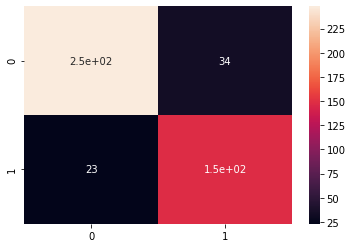

In [52]:
y_predict_test = NB_classifier.predict(X_test)
cm = confusion_matrix(y_test, y_predict_test)
sns.heatmap(cm, annot=True)

In [53]:
print(classification_report(y_test, y_predict_test))

              precision    recall  f1-score   support

           0       0.92      0.88      0.90       282
           1       0.81      0.87      0.84       171

    accuracy                           0.87       453
   macro avg       0.86      0.87      0.87       453
weighted avg       0.88      0.87      0.87       453



With labels produced using VADER, we get an accuracy of 87%